In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# 데이터 불러오기
data = pd.read_csv('OBS_ASOS_DD_20210104225316.csv', encoding = 'cp949')  # 2020-01-01~2010-01-01
data1 = pd.read_csv('OBS_ASOS_DD_20210104225407.csv', encoding = 'cp949') # 2010-01-02~2020-01-02
data2 = pd.read_csv('OBS_ASOS_DD_20210104225442.csv', encoding = 'cp949') # 2020-01-03~2021-01-03

data = pd.concat([data,data1,data2],axis=0).reset_index().drop('index',axis=1)

In [13]:
# 데이터 전처리  
# 강수, 적설량과 관련된 변수는 0으로 결측 채우기  
rain_col = [i for i in data.columns if '강수' in i]
snow_col = [i for i in data.columns if '적설' in i]

data[rain_col+snow_col] = data[rain_col+snow_col].fillna(0)

data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']] = data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']].fillna(0)

# 사용하지 않는 컬럼 버리기
data = data.drop(['기사','강수 계속시간(hr)','10분 최다 강수량(mm)'],axis=1)

time_col=[i for i in data.columns if '시각' in i]
data = data.drop(time_col, axis=1)

data = data.drop(['지점','지점명'], axis=1)

# 시간 순서로 학습시키기 위해 시간 정렬
data = data.sort_values('일시').interpolate(method='linear')

# 보간 후 결측치 없음을 확인
print('결측치 개수 =',data.isna().sum().sum())

결측치 개수 = 0


In [14]:
# 라벨값 설정
data['Y'] = data['평균기온(°C)'].shift(-2)
data = data.dropna()

# train, valid, test dataset 분리
train = data[data['일시']<'2013-01-01']
valid = data[data['일시']>='2013-01-01']
valid = valid[valid['일시']<'2017-01-01']
test = data[data['일시']>='2017-01-01']
print(' train set:',len(train),'개\n',
      'valid set:',len(valid),'개\n',
      'test set',len(test),'개')

# X와 Y분리
trainX,trainY = train.drop(['일시','Y'],axis=1), train['Y']
validX,validY = valid.drop(['일시','Y'],axis=1), valid['Y']
testX,testY = test.drop(['일시','Y'],axis=1), test['Y']

 train set: 4749 개
 valid set: 1461 개
 test set 1462 개


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [6]:
inputs_1 = tf.keras.Input(shape=(1,44))
rnn = tf.keras.layers.SimpleRNN(100, return_sequences=True)(inputs_1)
rnn = tf.keras.layers.SimpleRNN(100, return_sequences=False)(rnn)
output = tf.keras.layers.Dense(1)(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='mse', optimizer=optimizer)
RNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 44)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 1, 100)            14500     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 34,701
Trainable params: 34,701
Non-trainable params: 0
_________________________________________________________________


Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4680/4749 [============================>.] - ETA: 0s - loss: 113.0120
Epoch 00001: val_loss improved from inf to 104.00933, saving model to checkpoint.keras
4749/4749 [==============================] - 2s 351us/sample - loss: 112.5797 - val_loss: 104.0093
Epoch 2/200
4350/4749 [==========================>...] - ETA: 0s - loss: 70.1248
Epoch 00002: val_loss improved from 104.00933 to 49.44615, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 69us/sample - loss: 67.5237 - val_loss: 49.4461
Epoch 3/200
4440/4749 [===========================>..] - ETA: 0s - loss: 35.8549
Epoch 00003: val_loss improved from 49.44615 to 32.29552, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 68us/sample - loss: 35.3485 - val_loss: 32.2955
Epoch 4/200
4440/4749 [===========================>..] - ETA: 0s - loss: 28.6946
Epoch 00004: val_loss did not improve from 32.29552
4749/4749 [===

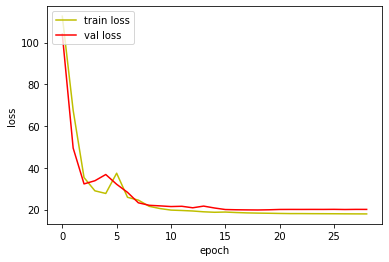

In [7]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(trainX.values.reshape(-1,1,44),trainY, validation_data=(validX.values.reshape(-1,1,44), validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_RNN =  3.363541114138681


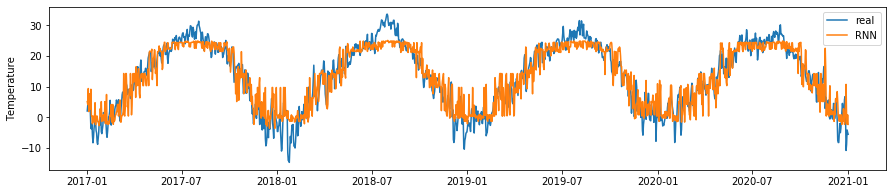

In [8]:
time = pd.to_datetime(test['일시'])

pred_RNN = RNN.predict(testX.values.reshape(-1,1,44)).reshape(-1,)


plt.figure(figsize = (15,3))
plt.plot(time,testY.reset_index()['Y'])
plt.plot(time,pred_RNN)

plt.ylabel('Temperature')
plt.legend(['real','RNN'])

print('MAE')
print('MAE_RNN = ',(((testY-pred_RNN.reshape(-1,))**2)**0.5).mean())

DNN으로 예측한 결과로 MAE를 계산했을 때, 2.x 정도 나왔다.  
RNN 결과는 3.x로 DNN보다 MAE도 낮고 그래프 상으로 보았을 때도 잘 예측하였다고 할 수 없다.  
여름과 겨울, 온도가 높아지고 낮아질 때 예측 정확도가 낮다.  
RNN을 잘못 쓰고 있는건 아닐까?

참고 글  
https://frhyme.github.io/machine-learning/simple_rnn/  
https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/  
https://dreamgonfly.github.io/blog/understanding-rnn/  
https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-27%EC%9D%BC%EC%B0%A8-rnn-many-to-one-9c785962960d

### RNN(Recurrent Neural Network)  
RNN은 시퀀스 데이터를 모델링 하기 위해 등장했다.  
위의 3개의 글을 보면 공통적으로 등장하는 그림이 있다.  
입력되는 데이터의 시퀀스 길이와 반환하는 시퀀스의 길이에 따라 RNN의 구조가 달라진다.  
이 구조를 모두 구현해보려한다.  
1) one to one  
2) one to many  
3) many to one  
4) many to many  
5) 또 다른 many to many  

1) one to one은 위에 구현되어 있는 RNN구조이다.  
먼저 그림과 같은 구조로 구현하기 위해 rnn층을 하나만 사용하여 구현하겠다.    

#### 1) one to one

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 44)]           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50)                4750      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4350/4749 [==========================>...] - ETA: 0s - loss: 173.9177
Epoch 00001: val_loss improved from inf to 133.86854, saving model to checkpoint.keras
4749/4749 [==============================] - 1s 191us/sample - loss: 169.9744 - val_loss: 133.8685
Epoch 2/200
4710/4749 [============================>.] - ETA: 0s - loss

3810/4749 [=======================>......] - ETA: 0s - loss: 17.3271
Epoch 00028: val_loss improved from 19.21353 to 19.16640, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 48us/sample - loss: 17.3116 - val_loss: 19.1664
Epoch 29/200
3930/4749 [=======================>......] - ETA: 0s - loss: 17.6194
Epoch 00029: val_loss improved from 19.16640 to 19.12703, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 47us/sample - loss: 17.2977 - val_loss: 19.1270
Epoch 30/200
3900/4749 [=======================>......] - ETA: 0s - loss: 17.3898
Epoch 00030: val_loss improved from 19.12703 to 19.08034, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 47us/sample - loss: 17.2761 - val_loss: 19.0803
Epoch 31/200
3930/4749 [=======================>......] - ETA: 0s - loss: 17.0639
Epoch 00031: val_loss did not improve from 19.08034
4749/4749 [==============================] - 0s 46us/sample - loss: 17.2

Epoch 59/200
3630/4749 [=====================>........] - ETA: 0s - loss: 16.1567
Epoch 00059: val_loss improved from 18.27439 to 18.23612, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 61us/sample - loss: 16.3989 - val_loss: 18.2361
Epoch 60/200
3960/4749 [========================>.....] - ETA: 0s - loss: 16.6847
Epoch 00060: val_loss did not improve from 18.23612
4749/4749 [==============================] - 0s 49us/sample - loss: 16.3825 - val_loss: 18.2559
Epoch 61/200
4170/4749 [=========================>....] - ETA: 0s - loss: 16.1648
Epoch 00061: val_loss improved from 18.23612 to 18.21540, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 46us/sample - loss: 16.3812 - val_loss: 18.2154
Epoch 62/200
4620/4749 [============================>.] - ETA: 0s - loss: 16.4937
Epoch 00062: val_loss improved from 18.21540 to 18.18975, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 54us/sample

Epoch 90/200
4350/4749 [==========================>...] - ETA: 0s - loss: 16.0401
Epoch 00090: val_loss did not improve from 17.68374
4749/4749 [==============================] - 0s 77us/sample - loss: 16.0369 - val_loss: 17.6838
Epoch 91/200
3900/4749 [=======================>......] - ETA: 0s - loss: 15.9259
Epoch 00091: val_loss improved from 17.68374 to 17.68354, saving model to checkpoint.keras

Epoch 00091: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
4749/4749 [==============================] - 0s 47us/sample - loss: 16.0368 - val_loss: 17.6835
Epoch 92/200
4080/4749 [========================>.....] - ETA: 0s - loss: 15.9958
Epoch 00092: val_loss did not improve from 17.68354
4749/4749 [==============================] - 0s 46us/sample - loss: 16.0366 - val_loss: 17.6835
Epoch 93/200
4170/4749 [=========================>....] - ETA: 0s - loss: 15.9278
Epoch 00093: val_loss did not improve from 17.68354

Epoch 00093: ReduceLROnPlateau reducing learning rate t

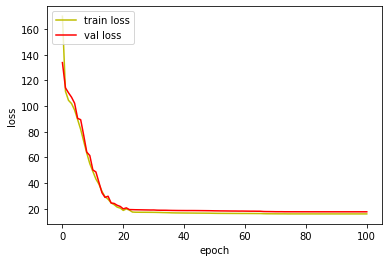

In [9]:
inputs_1 = tf.keras.Input(shape=(1,44))
rnn = tf.keras.layers.SimpleRNN(50, return_sequences=False)(inputs_1)
output = tf.keras.layers.Dense(1)(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='mse', optimizer=optimizer)
RNN.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(trainX.values.reshape(-1,1,44),trainY, validation_data=(validX.values.reshape(-1,1,44), validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_RNN =  3.2984198648854597


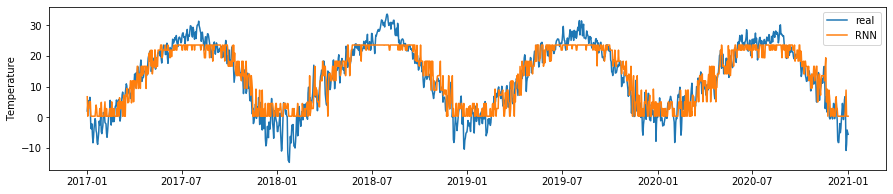

In [10]:
time = pd.to_datetime(test['일시'])

pred_RNN = RNN.predict(testX.values.reshape(-1,1,44)).reshape(-1,)


plt.figure(figsize = (15,3))
plt.plot(time,testY.reset_index()['Y'])
plt.plot(time,pred_RNN)

plt.ylabel('Temperature')
plt.legend(['real','RNN'])

print('MAE')
print('MAE_RNN = ',(((testY-pred_RNN.reshape(-1,))**2)**0.5).mean())

#### 2) one to many  
한장의 사진을 여러 단어로 이루어진 문장으로 학습하고 싶을 때 활용된다.  
입력과 출력 시퀀스 길이를 다르게 받는 모델을 설계하기 위해선 데이터 형태도 변형시켜야 한다  
모델 설계를 위해선 입력과 출력을 정의하여야 한다.  
one to many 형태의 rnn을 구현하기 위해 입력은 t시점의 기상 관측 데이터, 출력은 t+2,t+3,t+4 시점의 평균기온으로 정의한다.  

In [33]:
Y_len = 3
Y = [data['Y'].iloc[i:i+3].values for i in range(len(data)-2)]
data = data.drop(['Y'],axis=1).iloc[:-2]

In [36]:
# train, valid, test dataset 분리
train = data[data['일시']<'2013-01-01']
valid = data[data['일시']>='2013-01-01']
valid = valid[valid['일시']<'2017-01-01']
test = data[data['일시']>='2017-01-01']
print(' train set:',len(train),'개\n',
      'valid set:',len(valid),'개\n',
      'test set',len(test),'개')

# X와 Y분리
trainX = train.drop(['일시'],axis=1)
validX = valid.drop(['일시'],axis=1)
testX = test.drop(['일시'],axis=1)

trainY = Y[:len(trainX)]
validY = Y[len(trainX):len(trainX)+len(validX)]
testY = Y[-len(testX):]

 train set: 4749 개
 valid set: 1461 개
 test set 1460 개


one to many를 구현하기 위해 repeat vector를 사용하였다  
다른 방법은 없을까?  

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 44)]              0         
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 3, 44)             0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 3, 50)             4750      
_________________________________________________________________
dense_5 (Dense)              (None, 3, 1)              51        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
Train on 4749 samples, validate on 1461 samples
Epoch 1/200
3870/4749 [=======================>......] - ETA: 0s - loss: 196.8612
Epoch 00001: val_loss improved from inf to 145.55282, saving model to checkpoint.keras
4749/4749 [===========================

Epoch 28/200
3990/4749 [========================>.....] - ETA: 0s - loss: 17.0333
Epoch 00028: val_loss improved from 17.82258 to 17.54391, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 61us/sample - loss: 17.2152 - val_loss: 17.5439
Epoch 29/200
4050/4749 [========================>.....] - ETA: 0s - loss: 17.4341
Epoch 00029: val_loss improved from 17.54391 to 17.35840, saving model to checkpoint.keras

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
4749/4749 [==============================] - 0s 60us/sample - loss: 17.2176 - val_loss: 17.3584
Epoch 30/200
4740/4749 [============================>.] - ETA: 0s - loss: 16.9925
Epoch 00030: val_loss improved from 17.35840 to 17.23238, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 65us/sample - loss: 16.9989 - val_loss: 17.2324
Epoch 31/200
3840/4749 [=======================>......] - ETA: 0s - loss: 17.1237
Epoch 00031: val_loss improve

Epoch 59/200
3960/4749 [========================>.....] - ETA: 0s - loss: 16.4584
Epoch 00059: val_loss improved from 16.96795 to 16.96709, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 61us/sample - loss: 16.7023 - val_loss: 16.9671
Epoch 60/200
4020/4749 [========================>.....] - ETA: 0s - loss: 16.7085
Epoch 00060: val_loss improved from 16.96709 to 16.96648, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 61us/sample - loss: 16.7017 - val_loss: 16.9665
Epoch 61/200
4140/4749 [=========================>....] - ETA: 0s - loss: 16.8200
Epoch 00061: val_loss improved from 16.96648 to 16.96568, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 59us/sample - loss: 16.7013 - val_loss: 16.9657
Epoch 62/200
3960/4749 [========================>.....] - ETA: 0s - loss: 16.7289
Epoch 00062: val_loss did not improve from 16.96568
4749/4749 [==============================] - 0s 60us/sample

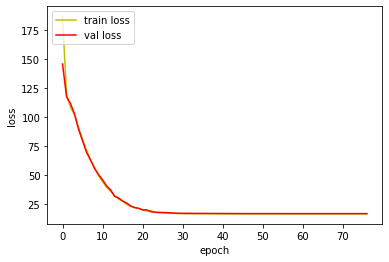

In [49]:
inputs_1 = tf.keras.Input(shape=44)
rnn = tf.keras.layers.RepeatVector(Y_len)(inputs_1)
rnn = tf.keras.layers.SimpleRNN(50, return_sequences=True)(rnn)
output = tf.keras.layers.Dense(1)(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='mse', optimizer=optimizer)
RNN.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(trainX.values,np.array(trainY).reshape(-1,3,1), validation_data=(validX.values, np.array(validY).reshape(-1,3,1)), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_RNN =  11.090407148280422


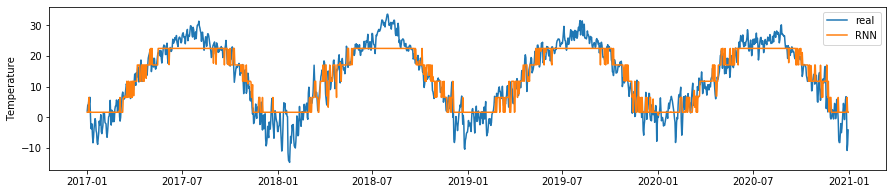

In [72]:
time = pd.to_datetime(test['일시'])
# 예측 시점
n = 0

pred = RNN.predict(testX)


plt.figure(figsize = (15,3))
plt.plot(time,np.array(testY)[:,n])
plt.plot(time,pred[:,n])

plt.ylabel('Temperature')
plt.legend(['real','RNN'])

print('MAE')
print('MAE_RNN = ',(((np.array(testY)[:,n]-pred[:,n])**2)**0.5).mean())

In [70]:
print('이틀 뒤를 예측한 결과, MAE = ',(((np.array(testY)[:,n]-pred[:,n])**2)**0.5).mean())
print('사흘 뒤를 예측한 결과, MAE = ',(((np.array(testY)[:,n+1]-pred[:,n])**2)**0.5).mean())
print('나흘 뒤를 예측한 결과, MAE = ',(((np.array(testY)[:,n+2]-pred[:,n])**2)**0.5).mean())

이틀 뒤를 예측한 결과, MAE =  11.090407148280422
사흘 뒤를 예측한 결과, MAE =  11.095054669144254
나흘 뒤를 예측한 결과, MAE =  11.100710918042278


먼 미래를 예측할수록 오차가 커지는 경향을 보인다.  

#### 3) many to one

tf.keras.layers.SimpleRNN  레이어 설명을 보면 다음과 같다.  